In [19]:
from agi.stk12.stkdesktop import STKDesktop
from agi.stk12.stkobjects import *
from agi.stk12.stkutil import *
from agi.stk12.vgt import *
import os
from tqdm import tqdm

In [3]:
# STK_PID = 12656  # 根据自己刚刚得到的PID
# stk = STKDesktop.AttachToApplication(pid=int(STK_PID))
stk = STKDesktop.StartApplication(visible=True) #using optional visible argument
root = stk.Root

In [6]:
scenario  = root.NewScenario('20220923')  # 新建场景

In [4]:
scenario = root.CurrentScenario # 链接当前场景 

# 创建星座的种子星

In [7]:
# 创建星座 —— 种子卫星
sat_seed = scenario.Children.New(AgESTKObjectType.eSatellite,'COL') # 种子卫星

In [8]:
# 种子卫星属性
sat_seed.SetPropagatorType(2) #  J4 摄动
keplerian = sat_seed.Propagator.InitialState.Representation.ConvertTo(1)  # eOrbitStateClassical, Use the Classical Element interface
keplerian.SizeShapeType = 0  # eSizeShapeAltitude, Changes from Ecc/Inc to Perigee/Apogee Altitude
keplerian.LocationType = 5  # eLocationTrueAnomaly, Makes sure True Anomaly is being used
keplerian.Orientation.AscNodeType = 0  # eAscNodeLAN, Use LAN instead of RAAN for data entry

# Assign the perigee and apogee altitude values:
keplerian.SizeShape.PerigeeAltitude = 600      # km 近地点 高度
keplerian.SizeShape.ApogeeAltitude = 600       # km 远地点 高度

# Assign the other desired orbital parameters:
keplerian.Orientation.Inclination = 75         # deg 倾角 
keplerian.Orientation.ArgOfPerigee = 0        # deg 近地点幅角度
keplerian.Orientation.AscNode.Value = 0       # deg
keplerian.Location.Value =  0              # deg 平近点角

# Apply the changes made to the satellite's state and propagate:
sat_seed.Propagator.InitialState.Representation.Assign(keplerian)
sat_seed.Propagator.Propagate()

# 添加传感器

In [9]:
# 添加传感器
sensor = sat_seed.Children.New(AgESTKObjectType.eSensor,'Cam')

In [10]:
# 传感器属性
sensor.CommonTasks.SetPatternSimpleConic(40,1) # 半张角40°，角分辨率1°
LOS = sensor.AccessConstraints.AddConstraint(34) # Range 类型
# 对照 https://help.agi.com/stkdevkit/Content/DocX/STKObjects~Enumerations~AgEAccessConstraints_EN.html 

In [11]:
# LOS = LOS.QueryInterface(STKObjects.IAgAccessCnstrMinMax)
LOS.EnableMax = True
LOS.Max = 1100

In [12]:
# 开始生成星座
root.ExecuteCommand('Walker */Satellite/COL Type Delta NumPlanes 16 NumSatsPerPlane 10 InterPlanePhaseIncrement 1 ColorByPlane Yes');

# 创建网格

In [13]:
covdef_tmp = scenario.Children.New(AgESTKObjectType.eCoverageDefinition,'CovDef')

In [14]:
covdef_tmp.Grid.BoundsType = 6
'''
1 Global
2 Latitude Bounds
3 Latitude Line
4 Longitude Line
5 Custom Boundary
6 LatLon Region
'''
covdef_tmp.Grid.Resolution.LatLon = 6
covdef_tmp.PointDefinition.Altitude = 10 # 10 km

all_list = covdef_tmp.AssetList.AvailableAssets
sensor_list = []
for e in range(len(all_list)):
    if e%2 == 0:
        pass
    else:
        sensor_list.append(all_list[e])

# 生成Walker星座

In [15]:
sate_constellation = scenario.Children.New(AgESTKObjectType.eConstellation,'COL')

In [20]:
for obj in tqdm(all_list):
    sate_constellation.Objects.Add(obj)

100%|███████████████████████████████████████████████████████████████████████████████| 322/322 [00:02<00:00, 139.54it/s]


In [21]:
for j in tqdm(sensor_list):
    covdef_tmp.AssetList.Add(j)

In [ ]:
from tqdm import tqdm
covdef_lits = []
for i in tqdm(range(0,310,10)):
    _string = 'CovDef' + str(i)
    covdef = scenario.Children.New(AgESTKObjectType.eCoverageDefinition, _string)
    covdef.Grid.BoundsType = 6
    covdef.Grid.Resolution.LatLon = 6
    covdef.PointDefinition.Altitude = i 
    for j in sensor_list:
        covdef.AssetList.Add(j)
    covdef_lits.append(covdef)

# 计算与绘图

In [22]:
figmerit1 = covdef_tmp.Children.New(AgESTKObjectType.eFigureOfMerit,'revisittime');

| 方法     | 变量值 | 描述|
| ----------- | ----------- |----------- |
|eFmAccessConstraint	|0	|Access Constraint Figure of Merit.|
|eFmAccessDuration	|1|	Access Duration Figure of Merit.|
|eFmAccessSeparation|	2|	Access Separation Figure of Merit.|
|eFmCoverageTime|	3	|Coverage Time Figure of Merit.|
|eFmDilutionOfPrecision|	4	|Dilution of Precision Figure of Merit.|
|eFmNAssetCoverage|	5	|N Asset Coverage Figure of Merit.|
|eFmNavigationAccuracy|	6|	Navigation Accuracy Figure of Merit.|
|eFmNumberOfAccesses|	7|	Number of Accesses Figure of Merit.|
|eFmNumberOfGaps|	8|	Number of Gaps Figure of Merit.|
|eFmResponseTime|	9	|Response Time Figure of Merit.|
|eFmRevisitTime	|10|	Revisit Time Figure of Merit.|
|eFmSimpleCoverage|	11|	Simple Coverage Figure of Merit.|
|eFmTimeAverageGap|	12	|Time Average Gap Figure of Merit.|
|eFmSystemResponseTime|	13|	System Response Time Figure of Merit.|
|eFmAgeOfData|	14	|Age of Data Figure of Merit.|
|eFmScalarCalculation|	15|	Scalar Calculation Figure of Merit.|
|eFmSystemAgeOfData	|16|	System Age Of Data Figure of Merit.|

In [24]:
figmerit1.SetDefinitionType(1)  # eFmAccessDuration 
covdef_tmp.ComputeAccesses();

In [70]:
pov = covdef_tmp.DataProviders.Item('Coverage by Latitude').Exec() # Coverage By Latitude

In [74]:
# pov.DataSets.GetDataSetByName('Start Time').GetValues
# pov.DataSets.GetDataSetByName('Percent')
data_array = pov.DataSets.ToArray()

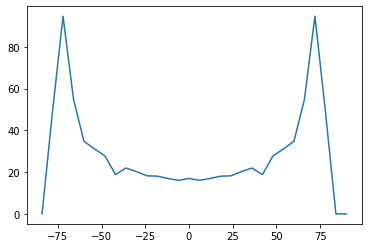

In [80]:
import numpy as np
from matplotlib import pyplot as plt
data_array = np.array(data_array)
x = []
y = []
for ele in data_array:
    x.append(ele[0])
    y.append(ele[1])
    pass

plt.plot(x,y)